##### This model follows the same fine tuning process as model 08, but with the weight decay rate of the model optimizer adjusted. The default weight decay used in previous models was 0.01. Here the rate is increased to 0.1 to test if this may provide some regularization to address the overfitting seen in the loss functions of previous models, and if this has a visible impact on model performance (rouge scores and quality of generated summaries)

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [5]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [6]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [7]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [8]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [9]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [10]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynamically pad inputs and labels

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [12]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [13]:
num_train_epochs = 25
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.1,
)

## Compile model

In [14]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [16]:
model_history = model.fit(tf_train, validation_data=tf_validation, callbacks=[early_stop], epochs=25)

Epoch 1/25
212/212 [==============================] - 32s 103ms/step - loss: 5.6214 - val_loss: 5.0163
Epoch 2/25
212/212 [==============================] - 21s 99ms/step - loss: 4.8860 - val_loss: 4.7800
Epoch 3/25
212/212 [==============================] - 21s 97ms/step - loss: 4.5429 - val_loss: 4.7127
Epoch 4/25
212/212 [==============================] - 21s 98ms/step - loss: 4.2843 - val_loss: 4.6376
Epoch 5/25
212/212 [==============================] - 20s 96ms/step - loss: 4.0704 - val_loss: 4.6143
Epoch 6/25
212/212 [==============================] - 21s 98ms/step - loss: 3.8794 - val_loss: 4.6078
Epoch 7/25
212/212 [==============================] - 20s 96ms/step - loss: 3.7111 - val_loss: 4.6423
Epoch 8/25
212/212 [==============================] - 20s 96ms/step - loss: 3.5619 - val_loss: 4.6607
Epoch 9/25
212/212 [==============================] - 20s 96ms/step - loss: 3.4156 - val_loss: 4.6802
Epoch 10/25
212/212 [==============================] - 20s 96ms/step - loss: 3.29

# Visualize model

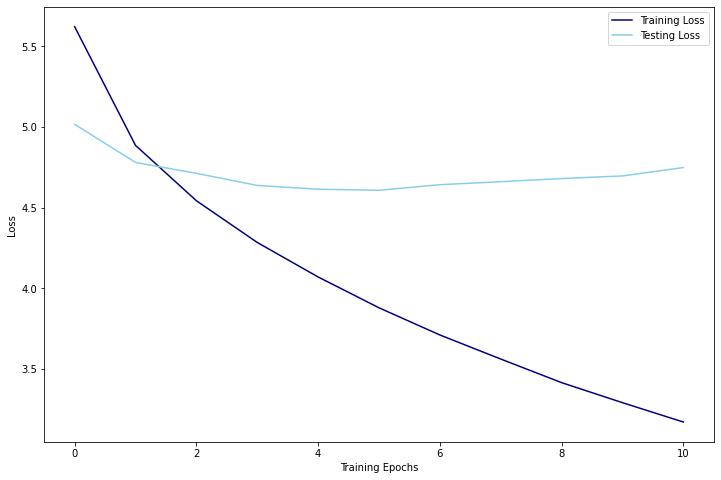

In [17]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. The loss functions of this model are very similar to those of model 8.

# Rouge scores for training data

In [18]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [33:21<00:00,  9.44s/it]


In [19]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 93.75
recall: 4.261363636363636
f-measure: 8.152173913043478
***************
rouge2
precision: 33.33333333333333
recall: 1.4245014245014245
f-measure: 2.7322404371584703
***************
rougeL
precision: 62.5
recall: 2.840909090909091
f-measure: 5.434782608695651
***************
rougeLsum
precision: 87.5
recall: 3.977272727272727
f-measure: 7.608695652173912
***************


# Rouge scores for test data

In [20]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [21]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [08:57<00:00,  9.12s/it]


In [22]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 64.15094339622641
recall: 14.847161572052403
f-measure: 24.113475177304966
***************
rouge2
precision: 13.461538461538462
recall: 3.070175438596491
f-measure: 5.0
***************
rougeL
precision: 37.735849056603776
recall: 8.73362445414847
f-measure: 14.184397163120568
***************
rougeLsum
precision: 56.60377358490566
recall: 13.100436681222707
f-measure: 21.276595744680854
***************


# Example model-generated summaries

In [23]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [24]:
print(rand_indexes)

[26, 23, 8]


In [25]:
print(test_labels[26])

The scene opens at the court of the Duke Orsino who is the leader of Illyria.
Other lords surround him, and music plays in the background.
He talks to a lord named Curio about his passionate love of the countess Olivia.
Olivia's brother, whom she was extremely close with, recently died and she was in mourning.
The duke's gentleman, Valentine, tells him that the countess is in mourning and will not accept any proposals.
Orsino is saddened by this, but will not give up his chase of her.


In [26]:
print(test_preds[26])

Duke of Albany, dressed as a fool, has become the first woman to win her.
He tells her that she has been killed.
Viola's brother, and dismisses them because of her illness.
They agree to take place in the house of Lady Olivia.


In [27]:
print(test_labels[23])

Mercedes goes to the house of the count, disguised.
She confronts the count, imploring him to spare Albert in the duel.
Yet Dantes is unyielding.
"Providence has punished him," he proclaims.
Now the life goal of Monte Cristo becomes clear: he believes God delivered him from prison to punish his enemies.
Yet by the end of the conversation the count has a change of heart, deciding that Albert will live but he himself will die  When Maximilien comes to Monte Cristo the next morning, ready for the duel, the count tells the young man   that Albert will live and he will die.
Maximilien is shocked by this change in attitude, yet proceeds with the duel as planned.
Before the duel is to commence, Albert asks to speak to the count.
Before Monte Cristo and the others, Albert admits that he was wrong and apologizes to the count, calling off the duel.
Albert and Mercedes both plan to leave the house, deciding to get on with their own lives apart from Fernand.
Monte Cristo begins to fall in love aga

In [28]:
print(test_preds[23])

In this chapter, the Count of Monte Cristo's son, Monsieur Villefort, tells him that he wants to marry Maximilian, and the family family to marry her.
The house of the house, which is one of the most important woman in the world,


In [29]:
print(test_labels[8])

Part2,  He hides the stolen items beneath a rock in a vacant lot.
When he realizes that he has successfully hidden them, another wave of joy passes through him, but it is soon replaced with hopelessness and disgust for everything around him.
He finds himself at his friend Razumikhin's apartment and enters in a state of near-delirium.
He realizes, after a feeble attempt to converse, that there is no one in the whole wide world he could effectively meet at this moment face to face.
He rejects Razumikhin's efforts to provide him with some lessons for pay and leaves.
Raskolnikov then wanders through the streets and at one point is given some money by someone mistaking him for a poor beggar (his clothes are rags).
He then returns home and dreams that one of the policeman is beating the landlady.
Part2,  After days spent in fevered delirium and illness, Raskolnikov awakes to discover Nastasia and a tradesman, whom he does not know, at his bedside.
Razumikhin, who has been caring for him, ent

In [30]:
print(test_preds[8])

In this chapter, the search for a man who has been working for a few days.
Analysis This is one of the most important man in the world, as he tries to steal his car from his car, and he finds out that he would have to go back to the ditch the river


# Evaluation of model

Based on rouge scores, this model performed better than the baseline and almost all previous finetuned models. The RougeL f1-score is very slightly lower than that of model 08, but all other scores are higher. Readability of summaries is similar to previous models.